# Generalized Entropy

This notebook aims at evaluating the **GEN method** (Generalized ENtropy).

This method consists in computing a generalized entropy score based on the softmax
probabilities. Considering the softmax output values $p_i$ (one per class), the OOD
score is defined as

$$ S(p) = \sum \_{j=1}^k p_i^\gamma (1-p_i)^\gamma. $$

The two parameters the method are:

- $\gamma$, corresponding to the order of the generalized entropy form, between 0 and 1.
  The authors of the original paper propose to set $\gamma=0.1$.
- $k$, corresponding to the top-k largest softmax values to keep in the entropy
  computation. Removing the smallest values makes the method more robust to small
  variations.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet20 model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**

[GEN: Pushing the Limits of Softmax-Based Out-of-Distribution Detection](https://openaccess.thecvf.com/content/CVPR2023/html/Liu_GEN_Pushing_the_Limits_of_Softmax-Based_Out-of-Distribution_Detection_CVPR_2023_paper.html),
CVPR 2023


### Imports


In [ ]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from oodeel.methods import GEN
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler
from oodeel.utils.torch_training_tools import train_torch_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First exp: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.

In [ ]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
data_handler = load_data_handler("torch")

# 1- Load train/test MNIST dataset
ds_train = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)
data_test = data_handler.load_dataset(
    "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
)

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_fit, _ = data_handler.split_by_class(ds_train, in_labels)
ds_in, ds_out = data_handler.split_by_class(data_test, in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["input"] = inputs["input"].float() / 255.0
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.


Test accuracy:	0.994967

=== Penultimate features viz ===


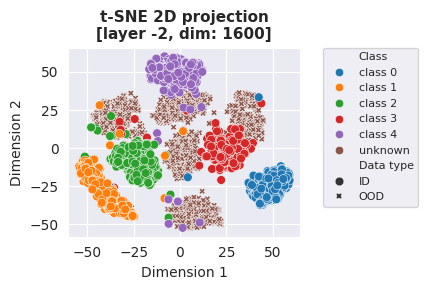

In [4]:
# === Train / Load model ===
# model path
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4")

try:
    # if the model exists, load it
    model = torch.load(os.path.join(model_path_mnist_04, "best.pt")).to(device)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }
    model = train_torch_model(ds_fit, **train_config).to(device)
    clear_output()

# evaluate model
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### GEN score

We now fit a GEN detector with MNIST[0-4] train dataset, and compare OOD scores returned
for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


=== Metrics ===
auroc      0.908102
fpr95tpr   0.445875

=== Plots ===


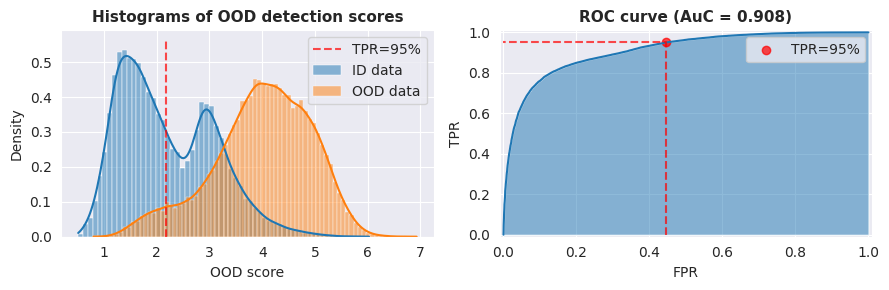

In [5]:
# === GEN scores ===
gen = GEN()
gen.fit(model)
scores_in, _ = gen.score(ds_in)
scores_out, _ = gen.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second exp: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [ ]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("torch")

# 1a- Load in-distribution dataset: CIFAR-10
ds_in = data_handler.load_dataset(
    "CIFAR10", load_kwargs={"root": data_path, "train": False, "download": True}
)
# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset(
    "SVHN", load_kwargs={"root": data_path, "split": "test", "download": True}
)


# 2- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    inputs["input"] = inputs["input"].float() / 255.0
    inputs["input"] = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )(inputs["input"])
    return inputs


ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["input", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["input", "label"]
)

clear_output()

### Model loading

The model is a **ResNet20** pretrained on CIFAR-10 and getting an accuracy score of
92.60%, loaded from
[pytorch-cifar-models](https://github.com/chenyaofo/pytorch-cifar-models) repository.


Test accuracy:	0.926000

=== Penultimate features viz ===


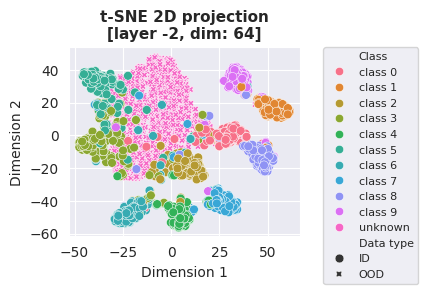

In [7]:
# === load model ===
# resnet20 pretrained on CIFAR-10
model = torch.hub.load(
    repo_or_dir="chenyaofo/pytorch-cifar-models",
    model="cifar10_resnet20",
    pretrained=True,
    verbose=False,
).to(device)
model.eval()

# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### GEN score

We now fit a GEN detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


=== Metrics ===
auroc      0.902954
fpr95tpr   0.312700

=== Plots ===


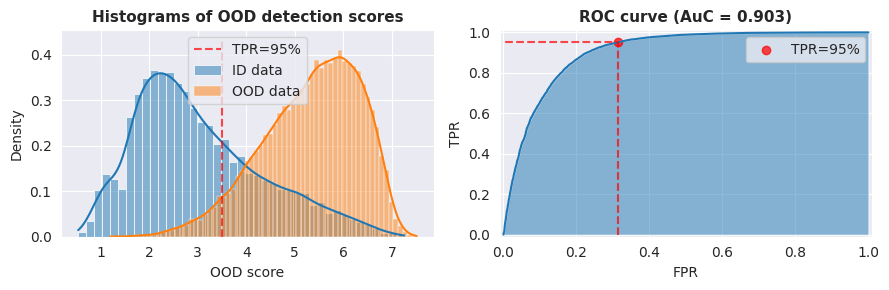

In [8]:
# === GEN scores ===
gen = GEN()
gen.fit(model)
scores_in, _ = gen.score(ds_in)
scores_out, _ = gen.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()